# Demo parameter sweeps of channel measurements
This demonstrates the construction of larger datasets built by looping across measurements of different channels.

In [1]:
from edge_analyzer import channel_waveform
from edge_analyzer.io import simulated_awgn
import xarray as xr

sample_rate_Hz = 15.36e6
analysis_bandwidth_Hz = 10e6

analysis_spec = {
    'power_time_series': {
        'detector_period': 10e-3,
        'detectors': ('rms', 'peak')
    },
    'cyclic_channel_power': {
        'cyclic_period': 10e-3,
        'detector_period': 1e-3 / 15 / 4,
        'detectors': ('rms', 'peak'),
        'cyclic_statistics': ('min', 'mean', 'max'),
    },
    'persistence_spectrum': {
        'window': 'flattop',
        'resolution': 15e3,
        'quantiles': [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1],
    },
    'amplitude_probability_distribution': {
        'power_low': -40,
        'power_high': 15,
        'power_count': 221,  # 0.25 dB resolution
    },
    'iq_waveform': {
        'start_time_sec': 0,
        'stop_time_sec': 100e-3
    }
}

filter_spec = {
    'ola': {
        'noverlap': 1024,
        'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
    },
}

acquisition_spec = {
    'duration': 0.2,
    'sample_rate': sample_rate_Hz
}

### Single acquisition

In [2]:
iq = simulated_awgn(
    **acquisition_spec, power=sample_rate_Hz / analysis_bandwidth_Hz
)

channel_waveform.from_spec(
    iq,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    filter_spec=filter_spec,
    analysis_spec=analysis_spec,
)

<xarray.Dataset> Size: 25MB
Dimensions:                             (power_detector: 2, time_elapsed: 20,
                                         persistence_statistic: 9,
                                         baseband_frequency: 667,
                                         iq_sample: 1536000,
                                         channel_power: 221,
                                         cyclic_statistic: 3, cyclic_lag: 600)
Coordinates:
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * time_elapsed                        (time_elapsed) float64 160B 0.0 ... 0.19
  * persistence_statistic               (persistence_statistic) <U5 180B '0.1...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
  * iq_sample                           (iq_sample) int64 12MB 0 1 ... 1535999
  * channel_power                       (channel_power) float64 2kB -40.0 ......
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
Data variables:
    power_time_series                   (power_detector, time_elapsed) float64 320B ...
    persistence_spectrum                (persistence_statistic, baseband_frequency) float64 48kB ...
    iq_waveform                         (iq_sample) complex64 12MB (0.8839912...
    amplitude_probability_distribution  (channel_power) float64 2kB 0.9999 .....
    cyclic_channel_power                (power_detector, cyclic_statistic, cyclic_lag) float64 29kB ...
Attributes:
    sample_rate_Hz:         15360000.0
    analysis_bandwidth_Hz:  10000000.0
    filter:                 {'ola': {'noverlap': 1024, 'window': 'hamming'}}

## RF parameter sweep
### Single parameter

In [3]:
data = []

for fc in [3705e6, 3715e6, 3725e6]:
    iq = simulated_awgn(
        **acquisition_spec, power=sample_rate_Hz / analysis_bandwidth_Hz
    )

    ret = channel_waveform.from_spec(
        iq,
        sample_rate_Hz,
        analysis_bandwidth_Hz=analysis_bandwidth_Hz,
        filter_spec=filter_spec,
        analysis_spec=analysis_spec,
    )

    data.append(ret.assign_coords({'center_frequency': [fc]}))

data = xr.combine_by_coords(data)
data

<xarray.Dataset> Size: 49MB
Dimensions:                             (power_detector: 2, time_elapsed: 20,
                                         center_frequency: 3,
                                         persistence_statistic: 9,
                                         baseband_frequency: 667,
                                         iq_sample: 1536000,
                                         channel_power: 221,
                                         cyclic_statistic: 3, cyclic_lag: 600)
Coordinates:
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * time_elapsed                        (time_elapsed) float64 160B 0.0 ... 0.19
  * persistence_statistic               (persistence_statistic) <U5 180B '0.1...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
  * iq_sample                           (iq_sample) int64 12MB 0 1 ... 1535999
  * channel_power                       (channel_power) float64 2kB -40.0 ......
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
  * center_frequency                    (center_frequency) float64 24B 3.705e...
Data variables:
    power_time_series                   (center_frequency, power_detector, time_elapsed) float64 960B ...
    persistence_spectrum                (center_frequency, persistence_statistic, baseband_frequency) float64 144kB ...
    iq_waveform                         (center_frequency, iq_sample) complex64 37MB ...
    amplitude_probability_distribution  (center_frequency, channel_power) float64 5kB ...
    cyclic_channel_power                (center_frequency, power_detector, cyclic_statistic, cyclic_lag) float64 86kB ...
Attributes:
    sample_rate_Hz:         15360000.0
    analysis_bandwidth_Hz:  10000000.0
    filter:                 {'ola': {'noverlap': 1024, 'window': 'hamming'}}

In [4]:
data = []

for atten in [0, 10]:
    for fc in [3705e6, 3715e6, 3725e6]:
        iq = simulated_awgn(
            **acquisition_spec, power=sample_rate_Hz / analysis_bandwidth_Hz
        )

        ret = channel_waveform.from_spec(
            iq,
            sample_rate_Hz,
            analysis_bandwidth_Hz=analysis_bandwidth_Hz,
            filter_spec=filter_spec,
            analysis_spec=analysis_spec,
        )

        data.append(ret.assign_coords({'center_frequency': [fc], 'attenuation': [atten]}))

dataset = xr.combine_by_coords(data)
dataset.center_frequency.attrs = {'label': 'RF center frequency', 'units': 'Hz'}
dataset.attenuation.attrs = {'label': 'External attenuation setting', 'units': 'dB'}

dataset.chunk({'iq_sample': int(dataset.attrs['sample_rate_Hz']*10e-3)}).to_zarr('dataset.zarr', mode='w')

dataset

<xarray.Dataset> Size: 87MB
Dimensions:                             (power_detector: 2, time_elapsed: 20,
                                         attenuation: 2, center_frequency: 3,
                                         persistence_statistic: 9,
                                         baseband_frequency: 667,
                                         iq_sample: 1536000,
                                         channel_power: 221,
                                         cyclic_statistic: 3, cyclic_lag: 600)
Coordinates:
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * time_elapsed                        (time_elapsed) float64 160B 0.0 ... 0.19
  * persistence_statistic               (persistence_statistic) <U5 180B '0.1...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
  * iq_sample                           (iq_sample) int64 12MB 0 1 ... 1535999
  * channel_power                       (channel_power) float64 2kB -40.0 ......
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
  * center_frequency                    (center_frequency) float64 24B 3.705e...
  * attenuation                         (attenuation) int64 16B 0 10
Data variables:
    power_time_series                   (attenuation, center_frequency, power_detector, time_elapsed) float64 2kB ...
    persistence_spectrum                (attenuation, center_frequency, persistence_statistic, baseband_frequency) float64 288kB ...
    iq_waveform                         (attenuation, center_frequency, iq_sample) complex64 74MB ...
    amplitude_probability_distribution  (attenuation, center_frequency, channel_power) float64 11kB ...
    cyclic_channel_power                (attenuation, center_frequency, power_detector, cyclic_statistic, cyclic_lag) float64 173kB ...
Attributes:
    sample_rate_Hz:         15360000.0
    analysis_bandwidth_Hz:  10000000.0
    filter:                 {'ola': {'noverlap': 1024, 'window': 'hamming'}}

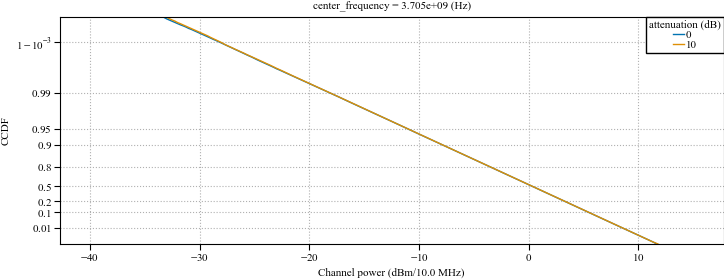

In [9]:
import iqwaveform
from edge_analyzer import figures
import matplotlib.pyplot as plt
plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()
apd = dataset.amplitude_probability_distribution.sel(center_frequency=3705e6)
apd.plot.line(x='channel_power', ax=ax)
ax.set_yscale('gamma-qq', k=1, db_ordinal=True)
figures.label_axis(ax.xaxis, apd, 'channel_power', tick_units=False)
figures.label_axis(ax.yaxis, apd)

In [6]:
import zarr

# assume we will want to read 10 ms at a time for performance reasons
chunks = {'iq_sample': int(dataset.attrs['sample_rate_Hz']*10e-3)}
store = zarr.ZipStore('xarray-sweep.zarr.zip', mode='w')
%timeit -n1 -r1 dataset.chunk(chunks).to_zarr(store)

72.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
